In [1]:
# sketch code taken from Madeleine.
# Minor modifications in reconstruct function (return array instead of LowRankOperator)
# moving to julia 0.6 : type -> mutable struct,  immutable -> struct

import Base: axpy!, scale!, ctranspose, dot, size, svds
import ArrayViews: view

#export AbstractSketch, AsymmetricSketch,
#	additive_update!, reconstruct

abstract AbstractSketch

# Asymmetric

type AsymmetricSketch<:AbstractSketch
	r::Int
	Omega::Array{Float64,2}
	Psi::Array{Float64,2}
	Y::Array{Float64,2}
	W::Array{Float64,2}
    
    A::Array{Float64,2}
    B::Array{Float64,2}
    rec::Bool
    
    function AsymmetricSketch(m::Int, n::Int, r::Int)
        k = 2r + 1
        l = 4r + 3 # == 2k+1
        Omega = randn(n,k)
        Psi   = randn(m,l)
        Y     = zeros(m,k)
        W     = zeros(n,l)
        
        A = Array{Float64,2}(0,0)
        B = Array{Float64,2}(0,0)
        new(r,Omega,Psi,Y,W,A,B,false)
    end
end 

function additive_update!(s::AsymmetricSketch, uvt, eta=1)
	# Y = Y + eta*v*v'*Omega
    axpy!(eta, uvt*s.Omega, s.Y)
	# W = W + eta*v*v'*Psi
	axpy!(eta, uvt'*s.Psi, s.W)
end

function reconstruct!(s::AsymmetricSketch, r::Int=s.r)
	# Q = orth(s.Y)
    if(s.rec)
        error("Warning : Already reconstructed!")
    end 
    s.rec = true
	k = 2r + 1
	l = 4r + 3
	Q,_ = qr(view(s.Y,:,1:k))
	B = view(s.W,:,1:l) / (Q'*view(s.Psi,:,1:l)) # Q's.Psi is k x l, its pinv is l x k, so B is n x k
	#U,S,V = mysvds(B, nsv=r) # U is n x r
	
    #println("sizes of q,b,u,s,v")
    #println(size(Q))
	#println(size(B))
	#println(size(U))
	#println(size(S))
	#println(size(V))
    #s.A = Q*V'
    #s.B = spdiagm(S)*U'
    s.A = Q
    s.B = B'
    #println("s.A size is $(size(s.A))")
    #println("s.B size is $(size(s.B))")
end

function col(s::AsymmetricSketch, i::Int)
    if(!s.rec)
        error("Not reconstructed yet!")
    end
    return s.A*s.B[:,i]
end 

function clear(s::AsymmetricSketch)
    m = size(s.Y)[1]
    n = size(s.W)[1]
    k = 2*s.r + 1
    l = 4*s.r + 3 # == 2k+1
    s.Omega = randn(n,k)
    s.Psi   = randn(m,l)
    s.Y     = zeros(m,k)
    s.W     = zeros(n,l)
    s.A = Array{Float64,2}(0,0)
    s.B = Array{Float64,2}(0,0)
    s.rec = false;
end 

### utilities
pos(a::Number) = max(a,0)
function pos(a::Array)
	for i in length(a)
		a[i] = pos(a[i])
	end
	a
end

function mysvds(args...; kwargs...)
  svdobj,_ = Base.svds(args...; kwargs...)
  return svdobj.U, svdobj.S, svdobj.Vt
end



Use "abstract type AbstractSketch end" instead.

mysvds (generic function with 1 method)

In [2]:
type wdim
    nX::Int
    nT::Int
    function wdim(nX,nT)
        new(nX,nT)
    end 
end 

function w(d,i)
    x = linspace(0,1,d.nX)
    t = linspace(0,1,d.nT)
    return sin.(2*pi*(t[i]+x))
end 

T, N} where N where T})(Ptr

w (generic function with 1 method)

{T}, Int64, Tuple{Vararg{Int64, N}}) in module ArrayViews at C:\Users\rm949\.julia\v0.6\ArrayViews\src\arrviews.jl:18 overwritten at C:\Users\rm949\.julia\v0.6\ArrayViews\src\arrviews.jl:26.


In [3]:
type parameters
    # Parameters.
    nX :: Int # Number of spatial mesh points
    nT :: Int # Number of timesteps
    theta :: Float64 # time-stepping parameter
    gamma :: Float64 # Robin's coefficient
    alpha :: Float64 # Control Penalty 
    
    dx :: Float64 # Difference between any two mesh nodes, (= h)
    x :: Array{Float64,1} # Mesh nodes. 
    dt :: Float64 # Difference between any two time steps
    t :: Array{Float64,1} # Time steps 
    
    u0 :: Array{Float64,1} # State at time 0.
    
    z0 :: Array{Float64,2} # Initial guess for Control
    
    d :: wdim # Desired state dimensions.
    
    M :: SymTridiagonal{Float64} # Mass Matrix
    A :: SymTridiagonal{Float64} # Stiffness Matrix 
    B :: SparseMatrixCSC{Float64,Int64} # Control Operator
    R :: Array{Float64,2} # Control Penalty Matrix
    
    G :: SymTridiagonal{Float64} 
    H :: SymTridiagonal{Float64}
    
    function parameters(nX = 256, nT = Int(5e2), theta = 0.5, gamma = 1e-1, alpha = 1e-4)
        dx = 1/(nX -1)
        
        x = Array(linspace(0,1,nX))
        t = Array(linspace(0,1,nT))
        
        dt = 1/(nT -1) 
        
        u0 = sin.(pi*x)  
    
        z0 = zeros(2,nT)
        
        d = wdim(nX,nT)
        #w = zeros(nX, nT)  

        #for i in 1:nT
        #    w[:,i] = sin(2*pi*(t[i] + x))
        #end 
        
        M,A,B,R = buildFEM(nX,gamma)
    
        G = M + theta*dt*A
        H = M - (1-theta)*dt*A
        
        new(nX,nT,theta,gamma,alpha,dx,x,dt,t,u0,z0,d,M,A,B,R,G,H)
    end 
end



In [4]:
function buildFEM(n::Int, gamma::Float64)
    h = 1/(n-1)

    o = h/6*ones(n-1)
    d = 4*h/6*ones(n)
    d[1]   = 2*h/6
    d[n] = 2*h/6
    M = SymTridiagonal(d,o)
    
    o = -1/h*ones(n-1)
    d = 2/h*ones(n)
    d[1]   = 1/h + gamma
    d[n] = 1/h + gamma
    A = SymTridiagonal(d,o)

    B = sparse([1,n],[1,2],[gamma,gamma])
    
    R = speye(2,2)
    
    return M,A,B,R
end 

buildFEM (generic function with 1 method)

In [5]:
function solve_state!(Z::Array{Float64,2}, U::AsymmetricSketch, p::parameters)
    if(U.rec)
        error("Can't Solve state when its already reconstructed!")
    end 
    nT = p.nT
    nX = p.nX
    dt = p.dt
    alpha = p.alpha
    theta = p.theta

    u1 = p.u0
    
    B = p.B
    G = p.B
    H = p.H
    
    M  = p.M
    R  = p.R
    d = p.d
    
    lu = lufact(full(p.G))
    
    u_temp = u1
    
    diff = u_temp-w(d,1)
    val = (1-theta)*( diff'*M*diff + alpha*Z[:,1]'*R*Z[:,1] )
    
    U_exact = zeros(p.nX,p.nT)
    U_exact[:,1] = u1
    
    I = collect(1:p.nX)    
    J = fill(1,p.nX)
    A = sparse(I,J,u1,p.nX,p.nT)
    additive_update!(U, A)
    
    for i in 1:nT-1
        Y = H*u_temp + dt*B*( theta*Z[:,i+1] + (1-theta)*Z[:,i] ) 
        u_temp = lu\Y
        
        if(i<nT-1)
            diff = u_temp-w(d,i+1)
            val += diff'*M*diff + alpha*Z[:,i]'*R*Z[:,i]
        else
            diff = u_temp-w(d,nT)
            val += theta*( diff'*M*diff + alpha*Z[:,nT]'*R*Z[:,nT] )
        end 
        U_exact[:,i+1] = u_temp
        reshape(u_temp,p.nX)
        J = fill(i,p.nX)
        A = sparse(I,J,u_temp,p.nX,p.nT)
        additive_update!(U,A)
    end
    reconstruct!(U,U.r)
    
    error = U_exact - U.A*U.B 
    
    val = 0.5*dt*val
    on = norm(error)
    fn = vecnorm(error)
    son = norm(U_exact)
    sfn = vecnorm(U_exact)
    return val, on/son, fn/sfn
end 

solve_state! (generic function with 1 method)

In [6]:
function evaluate_gradient!(Z::Array{Float64,2}, U::AsymmetricSketch, grad::Array{Float64,2}, p::parameters)
    if(!(U.rec))
        error("Can't evaluate gradient state when hasn't been reconstructed!")
    end 
    nT = p.nT
    nX = p.nX
    alpha = p.alpha
    theta = p.theta
    dt = p.dt
    
    d  = p.d
    
    M  = p.M
    R  = p.R
    H = p.H
    Bt   = p.B'
   
    lu = lufact(sparse(p.G))
  
    L2 = zeros(nX)# adjoint at i+1
    L1 = zeros(nX)# adjoint at i
    
    diff = col(U,nT)-w(d,nT)
    L2 = lu\ (-theta*dt*M*diff);
    
    grad[:,nT] = theta * dt * ( alpha*R*Z[:,nT] - Bt*L2 );
 
    for i in nT-1:-1:1
        diff = col(U,i)-w(d,i)
        L1 = lu\(H*L2 - dt*M*diff);
        grad[:,i] = dt * ( alpha*R*Z[:,i] - ( (1-theta)*Bt*L1 + theta*Bt*L2 ) );
        L2 = L1
    end
    
    diff = col(U,1)-w(d,1)
    L1 = lu\(H*L2 - (1-theta)*dt*diff)
    grad[:,1] = (1-theta) * dt * ( alpha*R*Z[:,1] - Bt*L1 );
end 

evaluate_gradient! (generic function with 1 method)

In [7]:
function minimize(z0::Array{Float64,2}, p::parameters)
    step_size = 1.0
    tol = 1e-3

    z = z0
    val = 0.0
    r = 20
    values = []
    U = AsymmetricSketch(p.nX,p.nT,20)
    grad = zeros(2,p.nT)
    
    α = 1 # α ∈ (0,0.5)
    β = 0.9  # β ∈ (0,1)

    
            
    max_iter = 1000
    onorm = []
    fnorm = []
    
    for i in 1:max_iter
        # solve state equation at current z
        on = 0
        fn = 0
        val,on,fn = solve_state!(z,U,p)
        # evaluate objective at current z
        #val = evaluate_objective(z,U,p)
        push!(values,val)
        push!(onorm,on)
        push!(fnorm,fn)
        
        # evaluate gradient at current z
        evaluate_gradient!(z,U,grad,p)
       
        if(i%100 == 0)
            println("Iteration $i")
            println("current obj is - $val")
        end 
        
        # backtracking LS        
        t = 100
        # t = 1e4/(max_iter)
        z = z - t*grad
        
        clear(U)
        obj,on,fn = solve_state!(z,U,p)
        #obj = evaluate_objective(z,U,p)
        
        s = p.dt*ones(p.nT)
        s[1] /= 2
        s[p.nT] /= 2
        S = inv(Diagonal(s))
        
        iter = 1
        max_b = 10
        rhs = val - α*t*dot(grad,grad*S)
        while( obj > rhs )
            if(iter > max_b)
                break
            end 
            t = β*t
            z = z - t*grad
            clear(U)
            obj,on,fn = solve_state!(z,U,p)
            rhs = val - α*t*dot(grad,grad*S)
            iter += 1
        end 
        clear(U)
    end
    
    clear(U)
    val,on,fn = solve_state!(z,U,p)
    #val = evaluate_objective(z,U,p)
    return z, U, val, values, onorm, fnorm
end   

minimize (generic function with 1 method)

In [8]:
p1 = parameters(256,502)
z01 = zeros(2,p1.nT)*1e-4


z1,U1,val1,values1,onorm1,fnorm1 = minimize(z01,p1)

  likely near In[8]:5
  likely near In[8]:5
  likely near In[8]:5
Stacktrace:
 [1] depwarn(::String, ::Symbol) at .\deprecated.jl:70
 [2] Array(::Type{Float64}, ::Tuple{Int64,Int64}) at .\deprecated.jl:57
 [3] qrfact(::ArrayViews.ContiguousView{Float64,2,Array{Float64,2}}, ::Type{T} where T) at .\linalg\qr.jl:274
 [4] #_qr#30 at .\linalg\qr.jl:296 [inlined]
 [5] (::Base.LinAlg.#kw##_qr)(::Array{Any,1}, ::Base.LinAlg.#_qr, ::ArrayViews.ContiguousView{Float64,2,Array{Float64,2}}, ::Type{Val{false}}) at .\<missing>:0
 [6] reconstruct!(::AsymmetricSketch, ::Int64) at .\In[1]:55
 [7] solve_state!(::Array{Float64,2}, ::AsymmetricSketch, ::parameters) at .\In[5]:53
 [8] minimize(::Array{Float64,2}, ::parameters) at .\In[7]:25
 [9] include_string(::String, ::String) at .\loading.jl:515
 [10] include_string(::Module, ::String, ::String) at C:\Users\rm949\.julia\v0.6\Compat\src\Compat.jl:478
 [11] execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\rm949\.julia\v0.6\IJulia\src\execute_reques

Iteration 100
current obj is - 0.30914678087543623
Iteration 200
current obj is - 0.2863766181403177
Iteration 300
current obj is - 0.27811696196936464
Iteration 400
current obj is - 0.27262825548853137
Iteration 500
current obj is - 0.2680339125237288
Iteration 600
current obj is - 0.2639819834072069
Iteration 700
current obj is - 0.2603655768327118
Iteration 800
current obj is - 0.25712417300567414
Iteration 900
current obj is - 0.2542112660714535
Iteration 1000
current obj is - 0.251588034050834


([-7.54488 -11.2402 … 0.0554297 0.0125676; -20.2834 -24.0357 … -0.0485966 -0.0125676], AsymmetricSketch(20, [0.798047 -1.40869 … -1.81121 0.264541; 1.79687 0.932992 … -0.915098 0.344561; … ; 1.44285 -0.928908 … 0.0740749 -0.115004; -0.568668 0.850905 … -0.457567 -2.10136], [0.843707 -1.72099 … -0.864934 -0.467424; -0.382225 0.46379 … 0.226372 0.0127338; … ; 0.518098 -0.827966 … 0.393665 0.855161; 0.33223 -0.358057 … -0.928203 -0.830092], [-4.72514 2.61099 … -5.35733 2.24505; -4.69834 2.72827 … -5.49106 2.28798; … ; 10.9231 3.92592 … -5.04722 3.16392; 10.9622 3.85558 … -4.91022 3.14362], [15.804 -6.8206 … -4.58899 -15.7586; 7.66809 -3.11929 … -2.10292 -8.0427; … ; 0.124304 -1.31999 … 1.6448 0.843633; 0.0 0.0 … 0.0 0.0], [-0.0441754 -0.0966167 … 0.0593245 0.0175255; -0.0439249 -0.0983975 … -0.039856 -0.025456; … ; 0.10212 0.0477137 … 0.0850561 0.0544826; 0.102485 0.0493719 … -0.127272 -0.0375987], [15.1642 7.36407 … -1.87517 -0.0; -15.3051 -7.56291 … 0.0855659 0.0; … ; 2.07324e-10 1.8720

In [9]:
using JLD, Plots, PyPlot

In [10]:
save("sketch-state1.jld", "data", U1)
save("sketch-control1.jld", "data", z1)
save("sketch-values1.jld","data",values1)
save("sketch-onorm1.jld","data",onorm1)
save("sketch-fnorm1.jld","data",fnorm1)


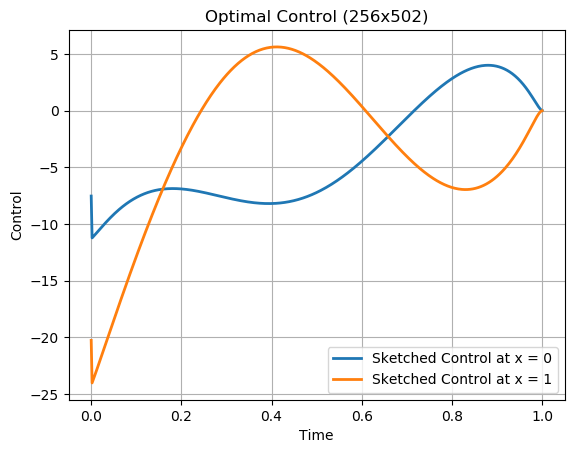

In [13]:
t = linspace(0,1,p1.nT); 
y1 = z1'[:,1]
y2 = z1'[:,2]
fig = figure("pyplot_annotation")
pl = PyPlot.plot(t,y1,label="Sketched Control at x = 0",lw=2) 

push!(pl,PyPlot.plot(t,y2,label="Sketched Control at x = 1",lw=2))

PyPlot.grid("on")
ax = axes()
#ax[:set_ylim]([0.26,0.43])
legend(loc="bottom right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Optimal Control (256x502)")
xlabel("Time")
ylabel("Control")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline



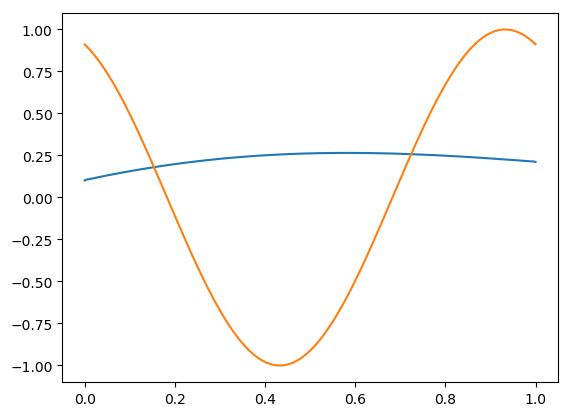

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003FFCCA58>
 PyObject <matplotlib.lines.Line2D object at 0x000000003FFCCB00>

In [15]:
x = linspace(0,1,p1.nX); y = hcat(col(U1,160),w(p1.d,160))
pl = PyPlot.plot(x,y)

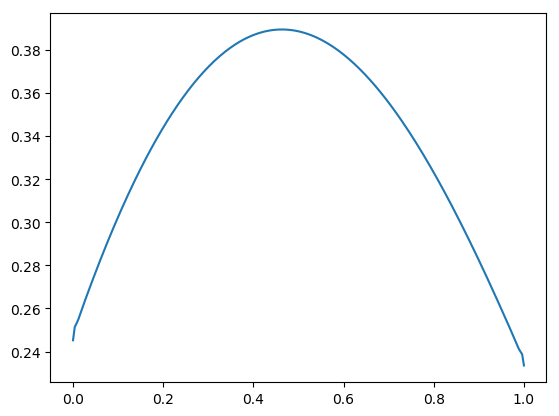

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000004024A748>

In [16]:
x = linspace(0,1,p1.nX); y = col(U1,100)
pl = PyPlot.plot(x,y)

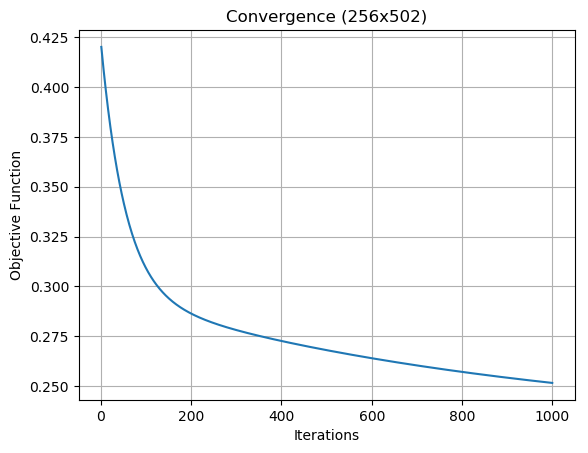

In [14]:
x = collect(1:1000)
y = values1
fig = figure("pyplot_annotation")
pl = PyPlot.plot(x,y)

PyPlot.grid("on")
ax = axes()
#ax[:set_ylim]([0.28,0.43])
legend(loc="upper right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Convergence (256x502)")
xlabel("Iterations")
ylabel("Objective Function")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline


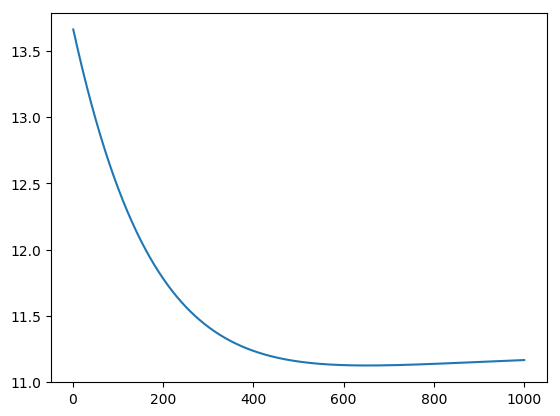

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000408F4CF8>

In [19]:
x = collect(1:1000)
y = onorm1
PyPlot.plot(x,y)

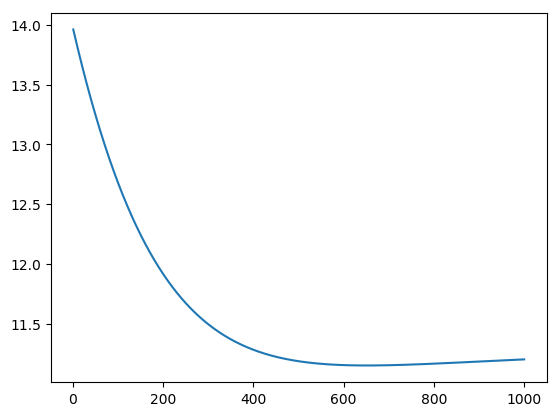

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003E377320>

In [20]:
x = collect(1:1000)
y = fnorm1
PyPlot.plot(x,y)

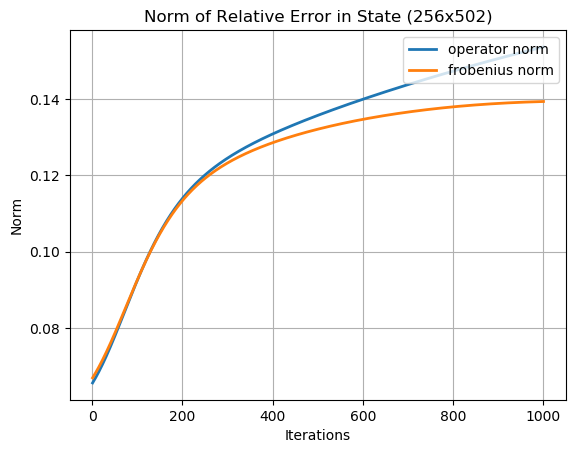

In [15]:
x = collect(1:1000)
fig = figure("pyplot_annotation")

pl = PyPlot.plot(x,onorm1,label="operator norm",lw=2)
push!(pl,PyPlot.plot(x,fnorm1,label="frobenius norm",lw=2))

PyPlot.grid("on")
ax = axes()
#ax[:set_ylim]([0.28,0.43])
legend(loc="upper right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Norm of Relative Error in State (256x502)")
xlabel("Iterations")
ylabel("Norm")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline

In [ ]:
x = collect(1:1000)
y = hcat(D3,D1)
PyPlot.plot(x,y)


In [16]:
d = load("values1.jld")
values1_non_sk = d["data"]
d = load("state1.jld")
U1_non_sk = d["data"]
d = load("control1.jld")
z1_non_sk = d["data"]
size(values1_non_sk)

(1000,)

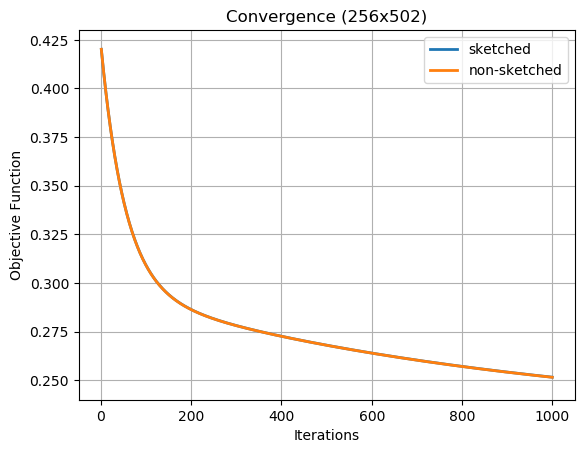

In [36]:
x = collect(1:1000)
fig = figure("pyplot_annotation")

pl = PyPlot.plot(x,values1,label="sketched",lw=2)
push!(pl,PyPlot.plot(x,values1_non_sk,label="non-sketched",lw=2))

PyPlot.grid("on")
ax = axes()
ax[:set_ylim]([0.24,0.43])
legend(loc="upper right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Convergence (256x502)")
xlabel("Iterations")
ylabel("Objective Function")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline

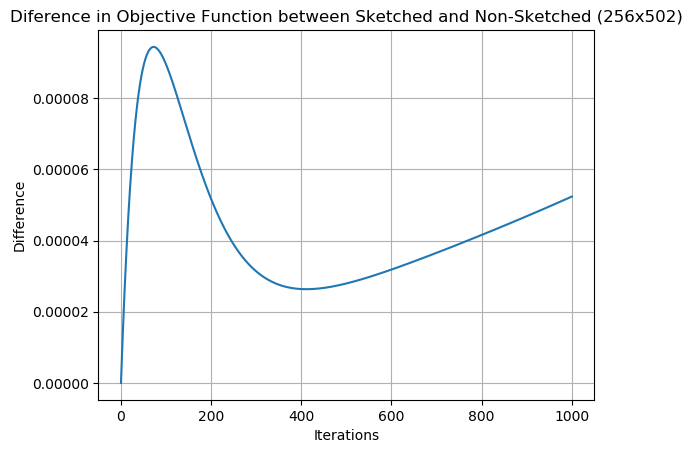

In [18]:
x = collect(1:1000)
fig = figure("pyplot_annotation")
y = values1-values1_non_sk
pl = PyPlot.plot(x,y)

PyPlot.grid("on")
ax = axes()
#ax[:set_ylim]([0.26,0.43])
legend(loc="upper right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Diference in Objective Function between Sketched and Non-Sketched (256x502)")
xlabel("Iterations")
ylabel("Difference")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline

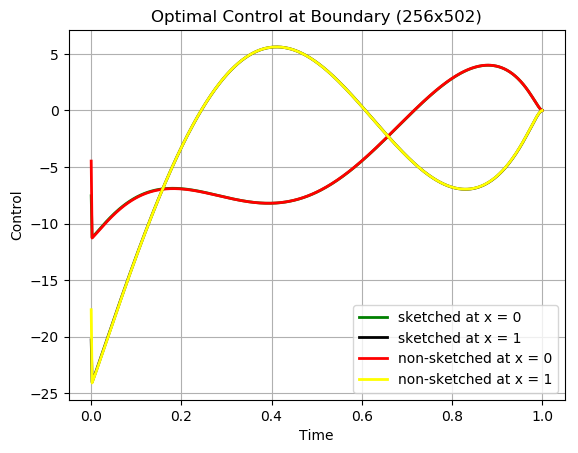

In [30]:
#p=parameters(1000,1200);
t = linspace(0,1,p1.nT); 
fig = figure("pyplot_annotation")
 
y1 = z1'[:,1]
y2 = z1'[:,2]
y3 = z1_non_sk'[:,1]
y4 = z1_non_sk'[:,2]

pl = PyPlot.plot(t,y1,color=:green,label="sketched at x = 0",lw=2)
push!(pl,PyPlot.plot(t,y2,color=:black,label="sketched at x = 1",lw=2))
push!(pl,PyPlot.plot(t,y3,color=:red,label="non-sketched at x = 0",lw=2))
push!(pl,PyPlot.plot(t,y4,color=:yellow,label="non-sketched at x = 1",lw=2))

PyPlot.grid("on")
legend(loc="lower right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Optimal Control at Boundary (256x502)")
xlabel("Time")
ylabel("Control")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline


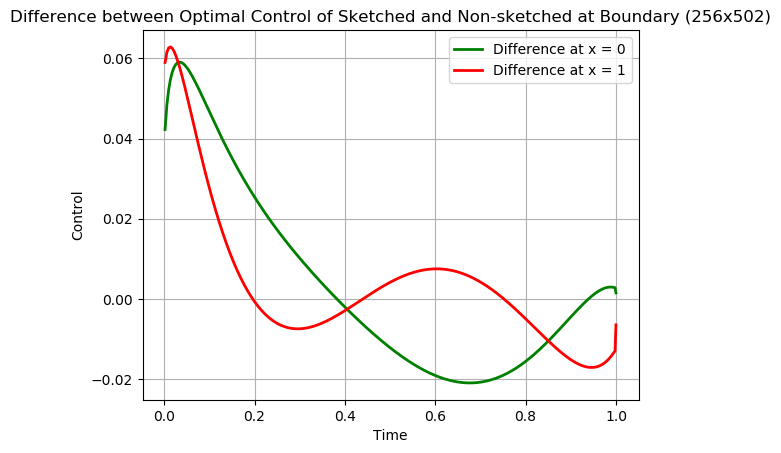

In [20]:
#p=parameters(1000,1200);
t = linspace(0,1,p1.nT); 
fig = figure("pyplot_annotation")
 
y1 = z1'[:,1]
y2 = z1'[:,2]
y3 = z1_non_sk'[:,1]
y4 = z1_non_sk'[:,2]

d1 = y1-y3
d2 = y2-y4

d1 = d1[2:502]
d2 = d2[2:502]
t = t[2:502]

pl1 = PyPlot.plot(t,d1,color=:green,label="Difference at x = 0",lw=2)
pl2 = PyPlot.plot(t,d2,color=:red,label="Difference at x = 1",lw=2)

PyPlot.grid("on")
legend(loc="upper right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Difference between Optimal Control of Sketched and Non-sketched at Boundary (256x502)")
xlabel("Time")
ylabel("Control")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline


In [41]:

y1 = z1'[:,1]
y2 = z1'[:,2]
y3 = z1_non_sk'[:,1]
y4 = z1_non_sk'[:,2]
d1 = y1-y3
d2 = y2-y4

println(size(d1))
d1[245]


(502,)


0.00231278099480825

In [11]:
p2 = parameters(1000,1200)
z02 = zeros(2,p2.nT)*1e-4


z2,U2,val2,values2,onorm2,fnorm2 = minimize(z02,p2)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at .\deprecated.jl:70
 [2] Array(::Type{Float64}, ::Tuple{Int64,Int64}) at .\deprecated.jl:57
 [3] qrfact(::ArrayViews.ContiguousView{Float64,2,Array{Float64,2}}, ::Type{T} where T) at .\linalg\qr.jl:274
 [4] #_qr#30 at .\linalg\qr.jl:296 [inlined]
 [5] (::Base.LinAlg.#kw##_qr)(::Array{Any,1}, ::Base.LinAlg.#_qr, ::ArrayViews.ContiguousView{Float64,2,Array{Float64,2}}, ::Type{Val{false}}) at .\<missing>:0
 [6] reconstruct!(::AsymmetricSketch, ::Int64) at .\In[1]:55
 [7] solve_state!(::Array{Float64,2}, ::AsymmetricSketch, ::parameters) at .\In[5]:53
 [8] minimize(::Array{Float64,2}, ::parameters) at .\In[7]:25
 [9] include_string(::String, ::String) at .\loading.jl:515
 [10] include_string(::Module, ::String, ::String) at C:\Users\rm949\.julia\v0.6\Compat\src\Compat.jl:478
 [11] execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\rm949\.julia\v0.6\IJulia\src\execute_request.jl:154
 [12] eventloop(::ZMQ.Socket) at C:\Users\rm949\.julia\v0

Iteration 100
current obj is - 0.35070297841061093
Iteration 200
current obj is - 0.31692344443362686
Iteration 300
current obj is - 0.2999872476149282
Iteration 400
current obj is - 0.2908257875755442
Iteration 500
current obj is - 0.2852903006406842
Iteration 600
current obj is - 0.28148025846047386
Iteration 700
current obj is - 0.2785227675512394
Iteration 800
current obj is - 0.27601486132332476
Iteration 900
current obj is - 0.2737686456962567
Iteration 1000
current obj is - 0.2716948153339764


([-5.08675 -8.6052 … 0.00555607 0.00148179; -10.928 -14.3886 … -0.00768449 -0.00148179], AsymmetricSketch(20, [-1.13947 1.83499 … 0.692932 -1.73887; -0.862961 0.581159 … -1.70462 -0.123689; … ; -0.0233371 -1.2233 … 1.36811 -1.19303; 0.0548977 0.375313 … 0.0639005 0.275678], [-0.180813 -0.556886 … -0.345649 -0.790464; 0.566965 -0.809004 … 1.86281 -1.5477; … ; -1.04592 0.0753225 … 1.70334 -1.93087; 0.720164 -0.229463 … 0.740525 -0.263421], [0.0931479 -1.49159 … -2.07788 -1.03008; 0.140037 -1.53873 … -2.05584 -1.0276; … ; -6.59608 -6.0246 … -0.392785 2.65524; -6.63837 -5.99627 … -0.407317 2.66198], [57.1098 67.7936 … -53.444 -8.80681; 28.3218 34.0169 … -26.896 -4.43546; … ; -1.98374 -6.35178 … 3.37896 0.737866; 0.0 0.0 … 0.0 0.0], [-0.000383612 -0.0875722 … 0.116015 0.0722647; -0.000576717 -0.0921566 … 0.0830619 0.0534686; … ; 0.0271647 -0.0654392 … -0.103204 -0.0594927; 0.0273389 -0.0621007 … -0.149347 -0.0934858], [42.1863 20.9062 … -3.05109 0.0; 2.18947 0.740526 … 0.464311 0.0; … ; 4.5

In [12]:
save("sketch-state2.jld", "data", U2)
save("sketch-control2.jld", "data", z2)
save("sketch-values2.jld","data",values2)


In [39]:
save("sketch-onorm2.jld","data",onorm2)
save("sketch-fnorm2.jld","data",fnorm2)


In [21]:
z2_non_sk = load("control2.jld")
z2_non_sk = z2_non_sk["data"]
U2_non_sk = load("state2.jld")
U2_non_sk = U2_non_sk["data"]
values2_non_sk = load("values2.jld")
values2_non_sk = values2_non_sk["data"];

In [23]:
z2_non_sk

2×1200 Array{Float64,2}:
 -3.67534   -8.61106   -8.59773   -8.58397  …   0.00398914   0.000672592
 -9.59167  -14.396    -14.3598   -14.3232      -0.00797648  -0.0016508  

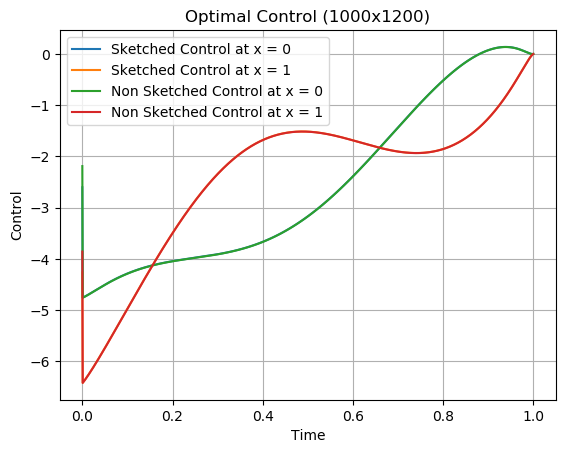

In [69]:
t = linspace(0,1,p2.nT); 
y1 = z2'[:,1]
y2 = z2'[:,2]
y3 = (z2_non_sk)'[:,1]
y4 = (z2_non_sk)'[:,2]
fig = figure("pyplot_annotation")
pl = PyPlot.plot(t,y1,label="Sketched Control at x = 0") 

push!(pl,PyPlot.plot(t,y2,label="Sketched Control at x = 1"))


push!(pl,PyPlot.plot(t,y3,label="Non Sketched Control at x = 0"))

push!(pl,PyPlot.plot(t,y4,label="Non Sketched Control at x = 1"))

PyPlot.grid("on")
ax = axes()
#ax[:set_ylim]([0.26,0.43])
legend(loc="bottom right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Optimal Control (1000x1200)")
xlabel("Time")
ylabel("Control")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline

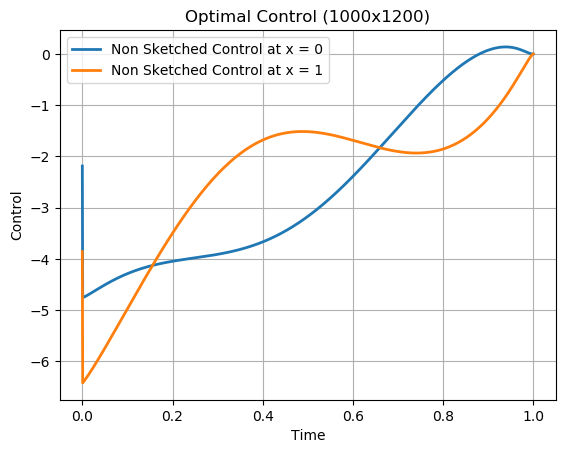

In [61]:
t = linspace(0,1,p2.nT); 
y1 = z2'[:,1]
y2 = z2'[:,2]
y3 = (z2_non_sk)'[:,1]
y4 = (z2_non_sk)'[:,2]
fig = figure("pyplot_annotation")
#pl = PyPlot.plot(t,y1,label="Sketched Control at x = 0",lw=2) 

#push!(pl,PyPlot.plot(t,y2,label="Sketched Control at x = 1",lw=2))


pl = PyPlot.plot(t,y3,label="Non Sketched Control at x = 0",lw=2)

push!(pl,PyPlot.plot(t,y4,label="Non Sketched Control at x = 1",lw=2))

PyPlot.grid("on")
ax = axes()
#ax[:set_ylim]([0.26,0.43])
legend(loc="bottom right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Optimal Control (1000x1200)")
xlabel("Time")
ylabel("Control")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline

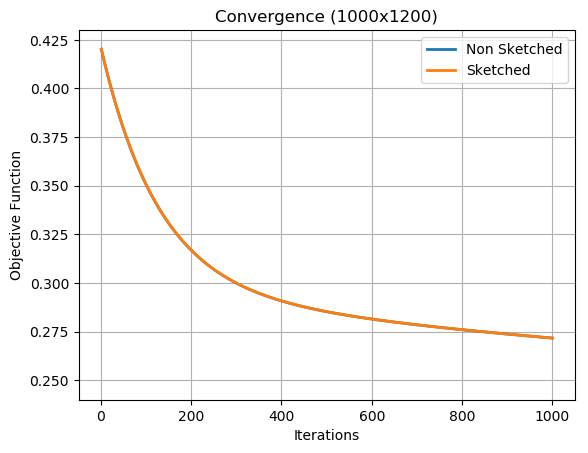

In [32]:
x = collect(1:1000)
y1 = values2_non_sk
y2 = values2
fig = figure("pyplot_annotation")
pl = PyPlot.plot(x,y1,label="Non Sketched",lw=2)
push!(pl,PyPlot.plot(x,y2,label="Sketched",lw=2))

PyPlot.grid("on")
ax = axes()
ax[:set_ylim]([0.24,0.43])
legend(loc="upper right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Convergence (1000x1200)")
xlabel("Iterations")
ylabel("Objective Function")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline


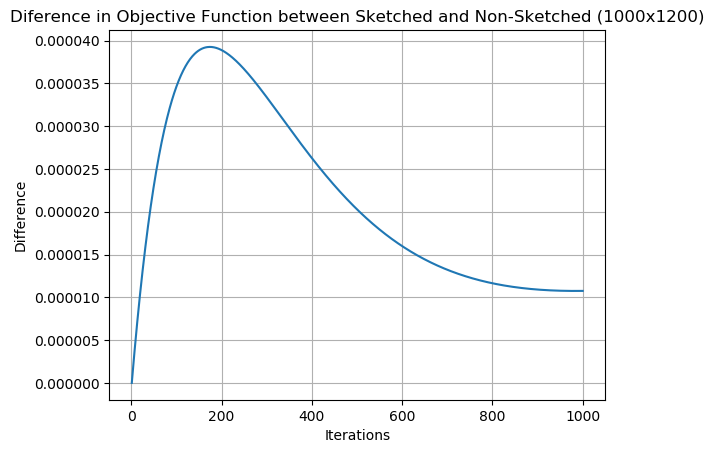

In [37]:
x = collect(1:1000)
fig = figure("pyplot_annotation")
y = values2-values2_non_sk
pl = PyPlot.plot(x,y)

PyPlot.grid("on")
ax = axes()
#ax[:set_ylim]([0.26,0.43])
legend(loc="upper right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Diference in Objective Function between Sketched and Non-Sketched (1000x1200)")
xlabel("Iterations")
ylabel("Difference")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline

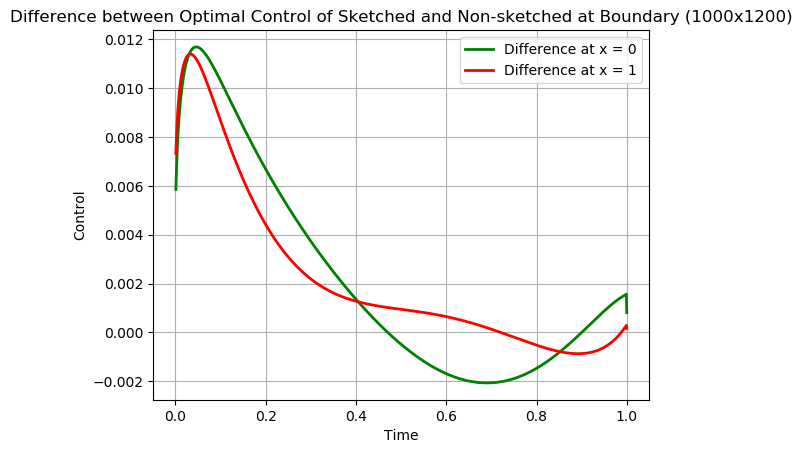

In [38]:
#p=parameters(1000,1200);
t = linspace(0,1,p2.nT); 
fig = figure("pyplot_annotation")
 
y1 = z2'[:,1]
y2 = z2'[:,2]
y3 = z2_non_sk'[:,1]
y4 = z2_non_sk'[:,2]

d1 = y1-y3
d2 = y2-y4

d1 = d1[2:1200]
d2 = d2[2:1200]
t = t[2:1200]

pl1 = PyPlot.plot(t,d1,color=:green,label="Difference at x = 0",lw=2)
pl2 = PyPlot.plot(t,d2,color=:red,label="Difference at x = 1",lw=2)

PyPlot.grid("on")
legend(loc="upper right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Difference between Optimal Control of Sketched and Non-sketched at Boundary (1000x1200)")
xlabel("Time")
ylabel("Control")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline


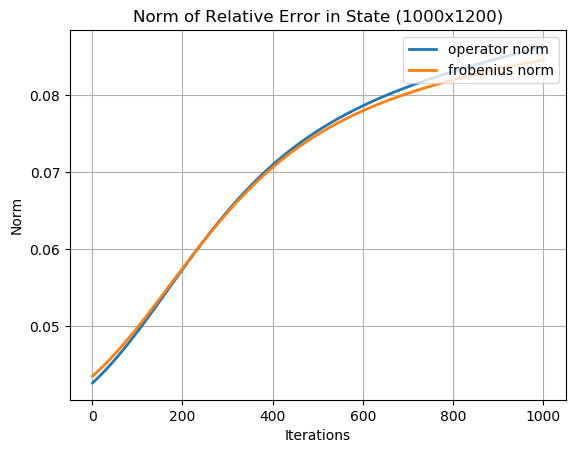

In [40]:
x = collect(1:1000)
fig = figure("pyplot_annotation")

pl = PyPlot.plot(x,onorm2,label="operator norm",lw=2)
push!(pl,PyPlot.plot(x,fnorm2,label="frobenius norm",lw=2))

PyPlot.grid("on")
ax = axes()
#ax[:set_ylim]([0.28,0.43])
legend(loc="upper right",fancybox="true") # Create a legend of all the existing plots using their labels as names
title("Norm of Relative Error in State (1000x1200)")
xlabel("Iterations")
ylabel("Norm")
fig[:canvas][:draw]() # Update the figure
#gcf() # Needed for IJulia to plot inline